In [1]:
!pip install -r requirements.txt -q
!sudo apt-get update -q && sudo apt-get install -y libgl1 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires onnxruntime<2,>=1.15.0, which is not installed.
autogluon-multimodal 1.4.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires numpy<=2.0.1, but you have numpy 2.2.6 which is incompatible.
amazon-sagemaker-sql-magic 0.1.4 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
autogluon-multimodal 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
autogluon-timeseries 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.2.6 which is incompatible.
langchain-aws 0.2.19 requires boto3>=1.37.24, but you hav

In [2]:
#manipolazione dati 
import cv2
import numpy as np 

#sistema
import os
import gc

#displaying a video 
from IPython.display import HTML,display, clear_output

#loading mat
from scipy.io import loadmat
import mat73


#visualizzazione
import matplotlib.pyplot as plt
from PIL import Image

#utility 
import re
from base64 import b64encode
from src.utils import utility_fun as uf

In [3]:
#folder 
path_env_dict=uf.get_path_env()
RAW_VIDEO= path_env_dict['RAW_VIDEO']
#from unimi
FIX_DATA_NEW= path_env_dict['FIX_DATA_NEW']
RAW_DB_PATH = path_env_dict['RAW_DB_PATH'] 
RAW_FIX_DURATION_PATH = path_env_dict['RAW_FIX_DURATION_PATH']
GAUSSIAN_TARGET_PATH=path_env_dict["GAUSSIAN_TARGET_PATH"]
WEIGHT_GAUSSIAN_TARGET_PATH=path_env_dict["WEIGHT_GAUSSIAN_TARGET_PATH"]
BINARY_TARGET_PATH=path_env_dict["BINARY_TARGET_PATH"]

### Goal:  costruzione immagini di output con i punti di fixation 
### Step: 
    1) costruzione dataset punti di fixation + durata a partire dal dataset fixation NEW 
    2) Per ogni video, per ogni frame, costruire mappa binaria sui punti di fixation (TBD)
    3) Per ogni video, per ogni frame, costruire mappa gaussiana sui punti di fixation  (1°dataset)
    4) Per ogni video, per ogni frame, costruire mappa gaussiana sui punti di fixation usando la durata come peso per denotare anche l'intensità del gaze nel punto (2°dataset) 

### 1) costruzione dataset punti di fixation + durata a partire dal dataset fixation NEW 

In [6]:
#var for testing
VIDEO_ID='001'
obs_id=0
mat_data_fix_new,_ = uf.load_mat_data(os.path.join(FIX_DATA_NEW,f'{str(VIDEO_ID).zfill(3)}.mat'))
fix_points_per_frame, observer_count,frame_count =uf.get_fixation_points_per_obs(fix_data=mat_data_fix_new, obs_id=obs_id)

****reading new mat data
reading mat success!********


In [7]:
def create_fixations_with_duration(fixations):
    fixations = np.asarray(fixations)
    durations = np.zeros(len(fixations), dtype=int)
    #trova  i punti di cambiamento rispetto ad entrambi assi
    change_indices = np.where(np.any(fixations[1:] != fixations[:-1], axis=1))[0] + 1
    split_indices = np.concatenate(([0], change_indices, [len(fixations)]))
    for i in range(len(split_indices) - 1):
        start, end = split_indices[i], split_indices[i + 1]
        duration = end - start
        durations[start:end] = duration
    # Stack con fixations
    return np.hstack((fixations, durations.reshape(-1,1)))

#### esempio su subset 

In [8]:
test_point_per_frame=fix_points_per_frame[:10,:10]
print('***Subset punti di fixation==>\n', test_point_per_frame)

***Subset punti di fixation==>
 [[533 357]
 [533 357]
 [758 340]
 [758 340]
 [758 340]
 [758 340]
 [758 340]
 [758 340]
 [821 337]
 [821 337]]


In [9]:
print('***Subset punti di fixation + durata==>\n',create_fixations_with_duration(fixations=test_point_per_frame))

***Subset punti di fixation + durata==>
 [[533 357   2]
 [533 357   2]
 [758 340   6]
 [758 340   6]
 [758 340   6]
 [758 340   6]
 [758 340   6]
 [758 340   6]
 [821 337   2]
 [821 337   2]]


### costrusci dataset per ciascun video e osservatore

In [10]:
for fix_data_ in os.listdir(FIX_DATA_NEW): 
    if fix_data_.endswith('.mat'):  
        VIDEO_ID = int(re.search(r'\d+', fix_data_).group())
        mat_data_fix_new,_ = uf.load_mat_data(os.path.join(FIX_DATA_NEW,fix_data_))
        observer_count,frame_count=uf.get_fixation_points_info(fix_data=mat_data_fix_new)
        aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=0) 
        #altezza x larghezza
        frame_shape=[aframe.shape[0],aframe.shape[1]]
        fix_with_duration_data={
            'VIDEO_ID':VIDEO_ID, 'FIX_DATA_NAME': fix_data_, 'FRAME_HW': frame_shape,
            'OBSERVER_CNT':observer_count,'FRAME_CNT': frame_count,  
            'OBSERVER_DATA' : {}}
        for obs_idx in range(observer_count):  
            #(fix_point, obs_count, frame count)-tripla
            fix_points_per_frame_tuple=uf.get_fixation_points_per_obs(fix_data=mat_data_fix_new, obs_id=obs_idx)
            if fix_points_per_frame_tuple: 
                #assegna lista =[frame x 3 ] 
                fix_with_duration_data['OBSERVER_DATA'][int(obs_idx)]=create_fixations_with_duration(fix_points_per_frame_tuple[0]).tolist()
                #print('number of frames=>',len(fix_with_duration_data['OBSERVER_DATA'][obs_idx]), '(x,y,duration)=>',fix_with_duration_data['OBSERVER_DATA'][obs_idx][0])
        #salva come json (un json per video)
        uf.write_json(data=fix_with_duration_data,path=os.path.join(RAW_FIX_DURATION_PATH,f'{VIDEO_ID}.json'))

****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
reading mat success!********
****reading new mat data
rea

#### controllo dataset creato

In [11]:
VIDEO_ID=1
fix_dur_js=uf.read_json(path=os.path.join(RAW_FIX_DURATION_PATH,f'{VIDEO_ID}.json'))
print('VIDEO_ID',fix_dur_js['VIDEO_ID'],'FIX NAME',fix_dur_js['FIX_DATA_NAME'],'FRAME SHAPE(hw)=>',fix_dur_js['FRAME_HW'],
      'OBSERVER_CNT',fix_dur_js['OBSERVER_CNT'],'FRAME COUNT=>',fix_dur_js['FRAME_CNT'],
      'OBSERVER DATA KEYS=>',fix_dur_js['OBSERVER_DATA'].keys(), 
      'FRAME CNT FIRST OBS=>',len(fix_dur_js['OBSERVER_DATA']['0']),
      '\n(x,y,duration) first obs at frame 0=>',fix_dur_js['OBSERVER_DATA']['0'][0],
      '\n(x,y,duration) first obs at frame 1=>',fix_dur_js['OBSERVER_DATA']['0'][1],
      '\n(x,y,duration) first obs at frame 0=>',fix_dur_js['OBSERVER_DATA']['0'][2])

VIDEO_ID 1 FIX NAME 001.mat FRAME SHAPE(hw)=> [720, 1280] OBSERVER_CNT 39 FRAME COUNT=> 600 OBSERVER DATA KEYS=> dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']) FRAME CNT FIRST OBS=> 600 
(x,y,duration) first obs at frame 0=> [533, 357, 2] 
(x,y,duration) first obs at frame 1=> [533, 357, 2] 
(x,y,duration) first obs at frame 0=> [758, 340, 6]


### 3) Costruzione mappa gaussiana punti di fixation

#### example with single video

In [3]:
VIDEO_ID=1
fix_dur_js=uf.read_json(path=os.path.join(RAW_FIX_DURATION_PATH,f'{VIDEO_ID}.json'))

In [4]:
fix_dur_js.keys()

dict_keys(['VIDEO_ID', 'FIX_DATA_NAME', 'FRAME_HW', 'OBSERVER_CNT', 'FRAME_CNT', 'OBSERVER_DATA'])

In [5]:
frame_idx=0 
x_list=[]
y_list=[]
duration_list=[]
for obs_id in range(fix_dur_js['OBSERVER_CNT']):
    fix_dur_data=fix_dur_js['OBSERVER_DATA'][str(obs_id)][frame_idx] 
    x =fix_dur_data[0] 
    y =fix_dur_data[1] 
    duration_ = fix_dur_data[2] 
    x_list.append(x) 
    y_list.append(y) 
    duration_list.append(duration_) 
print('lens: x:',len(x_list),'y:',len(x_list),'duration:',len(duration_list))

lens: x: 39 y: 39 duration: 39


In [6]:
aframe=uf.read_specific_frame(video_path=os.path.join(RAW_VIDEO,str(VIDEO_ID).zfill(3)+'.mp4'),frame_idx=frame_idx) 
print('video frame shape==>',aframe.shape)

video frame shape==> (720, 1280, 3)


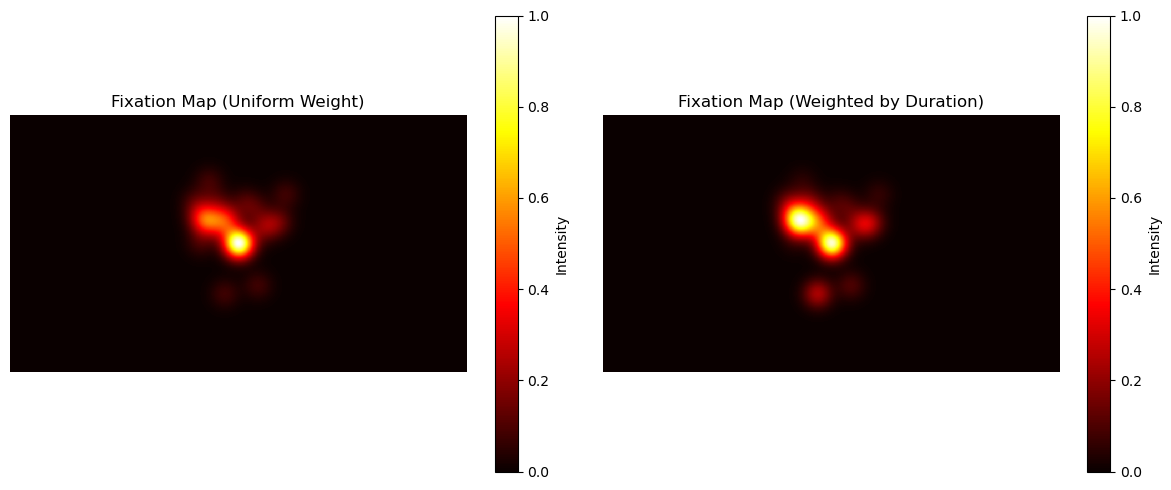

In [7]:
fix_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(aframe.shape[0],aframe.shape[1]), weight_in=None)
fix_map2=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(aframe.shape[0],aframe.shape[1]), weight_in=duration_list)

plt.figure(figsize=(12, 5))

# Fixation map without duration weighting
plt.subplot(1, 2, 1)
plt.imshow(fix_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Fixation Map (Uniform Weight)')
plt.axis('off')

# Fixation map with duration weighting
plt.subplot(1, 2, 2)
plt.imshow(fix_map2, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Fixation Map (Weighted by Duration)')
plt.axis('off')

plt.tight_layout()
plt.show()

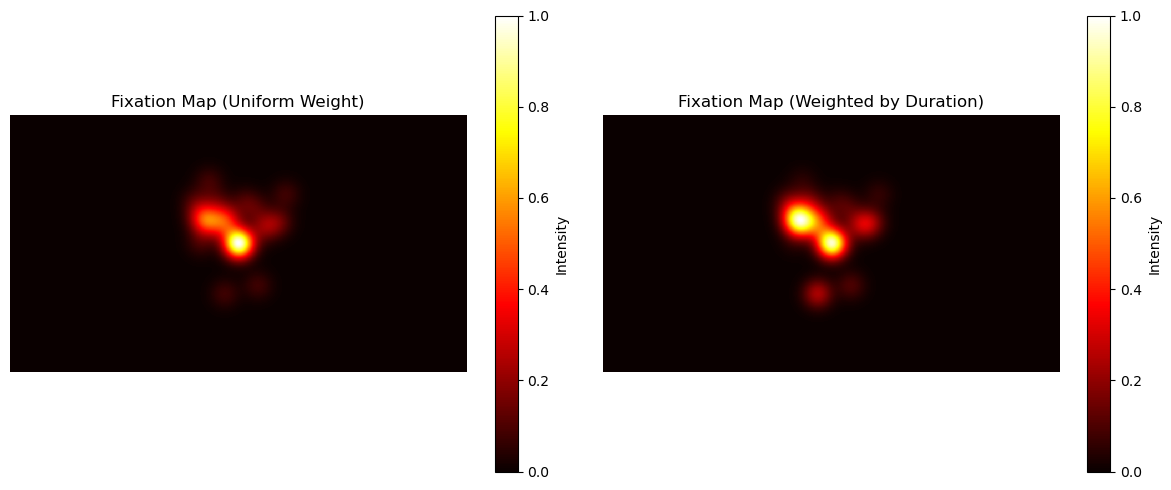

In [11]:
fix_map=uf.make_gauss_mask_for_fixdata(x=x_list, y=y_list, my_size=(aframe.shape[0],aframe.shape[1]), fix_time=None)
fix_map2=uf.make_gauss_mask_for_fixdata(x=x_list, y=y_list, my_size=(aframe.shape[0],aframe.shape[1]), fix_time=duration_list)

plt.figure(figsize=(12, 5))

# Fixation map without duration weighting
plt.subplot(1, 2, 1)
plt.imshow(fix_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Fixation Map (Uniform Weight)')
plt.axis('off')

# Fixation map with duration weighting
plt.subplot(1, 2, 2)
plt.imshow(fix_map2, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Fixation Map (Weighted by Duration)')
plt.axis('off')

plt.tight_layout()
plt.show()

### Costruzione mappe di output (ground truth) da usare 
    nota: i dataset effettivi (train,validation,test, modello,out-metric,input) verrano creati successivamente (valutare dizionari di split con i path)

In [3]:
os.listdir(RAW_FIX_DURATION_PATH)

['15.json',
 '2.json',
 '9.json',
 '23.json',
 '61.json',
 '31.json',
 '26.json',
 '22.json',
 '21.json',
 '45.json',
 '42.json',
 '40.json',
 '28.json',
 '30.json',
 '72.json',
 '10.json',
 '13.json',
 '33.json',
 '27.json',
 '69.json',
 '54.json',
 '58.json',
 '7.json',
 '38.json',
 '25.json',
 '53.json',
 '.ipynb_checkpoints',
 '65.json',
 '63.json',
 '67.json',
 '57.json',
 '11.json',
 '70.json',
 '24.json',
 '64.json',
 '35.json',
 '66.json',
 '47.json',
 '6.json',
 '50.json',
 '8.json',
 '14.json',
 '43.json',
 '20.json',
 '44.json',
 '1.json',
 '12.json',
 '5.json',
 '48.json',
 '62.json',
 '73.json',
 '37.json',
 '34.json',
 '56.json',
 '36.json',
 '16.json',
 '4.json',
 '74.json',
 '60.json',
 '71.json',
 '49.json',
 '68.json',
 '75.json',
 '18.json',
 '19.json',
 '3.json']

In [ ]:
for fix_data_js in os.listdir(RAW_FIX_DURATION_PATH): 
    if not fix_data_js.endswith('.json') or fix_data_js.replace('.json','') in os.listdir(BINARY_TARGET_PATH):
        continue
    print('to do=>',fix_data_js)
    VIDEO_ID = fix_data_js.split('.')[0]
    fix_dur_js_data=uf.read_json(path=os.path.join(RAW_FIX_DURATION_PATH,fix_data_js))
    FRAME_SHAPE = tuple(fix_dur_js_data['FRAME_HW'])
    FRAME_CNT=fix_dur_js_data['FRAME_CNT'] 
    for frame_idx in range(FRAME_CNT):  
        x_list=[]
        y_list=[]
        duration_list=[]
        for obs_id in range(fix_dur_js_data['OBSERVER_CNT']):
            fix_dur_data=fix_dur_js_data['OBSERVER_DATA'][str(obs_id)][frame_idx] 
            x =fix_dur_data[0] 
            y =fix_dur_data[1] 
            duration_ = fix_dur_data[2] 
            x_list.append(x) 
            y_list.append(y) 
            duration_list.append(duration_)
        #crea le mappe 
        gaussian_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), weight_in=None)
        weighted_gaussian_map=uf.make_gauss_mask(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]), weight_in=duration_list)
        binary_map = uf.make_binary_mask_for_fixdata(x=x_list, y=y_list, my_size=(FRAME_SHAPE[0],FRAME_SHAPE[1]))
        #nome mappa
        map_file_name=f'video{VIDEO_ID}_frame{frame_idx}_obs{obs_id}.png'
        #esporta ogni mappa 
        #crate folder wrt the video per each target path 
        for target_path in [GAUSSIAN_TARGET_PATH,WEIGHT_GAUSSIAN_TARGET_PATH,BINARY_TARGET_PATH]:
            dest_folder = os.path.join(target_path,f"{VIDEO_ID}")
            os.makedirs(dest_folder, exist_ok=True)
        uf.export_mask2image(my_mask=gaussian_map,path=os.path.join(GAUSSIAN_TARGET_PATH,f"{VIDEO_ID}",map_file_name))
        uf.export_mask2image(my_mask=weighted_gaussian_map,path=os.path.join(WEIGHT_GAUSSIAN_TARGET_PATH,f"{VIDEO_ID}",map_file_name))
        uf.export_mask2image(my_mask=binary_map,path=os.path.join(BINARY_TARGET_PATH,f"{VIDEO_ID}",map_file_name))

to do=> 37.json
to do=> 34.json
to do=> 4.json
to do=> 74.json
to do=> 60.json
to do=> 49.json


In [ ]:
print('done')


### spostamento in cartelle

In [9]:
import os
import shutil
import re

source_folder_list = [GAUSSIAN_TARGET_PATH,WEIGHT_GAUSSIAN_TARGET_PATH,BINARY_TARGET_PATH]
for source_folder in source_folder_list: 
    for filename in os.listdir(source_folder):
        if filename.endswith('.png') and filename.startswith('video'):
            match = re.match(r'video(\d+)_.*\.png', filename)
            if match:
                k = match.group(1)  # Numero K come stringa
                dest_folder = os.path.join(source_folder, k)
                os.makedirs(dest_folder, exist_ok=True)
                
                src_path = os.path.join(source_folder, filename)
                dest_path = os.path.join(dest_folder, filename)
                shutil.move(src_path, dest_path)